# Places for Half Earth Future
This is a new feature that will show precalculated biodiversity and contextual data for selected geometries around the globe (Up to 20 places per country)
Following this first approach there might be more narrative involved and a diffeent approach to how to show the data. Right now, the layer will be accessed from the 'Explore places' tab.

## Set up

In [21]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import arcgis
from arcgis.gis import GIS
import json
import pandas as pd
from arcgis.features import FeatureLayerCollection
import requests as re
from copy import deepcopy
from itertools import repeat
import functools


### Utils

**getHTfromId**

In [3]:
def getHTfromId(item_id):
    item = gis.content.get(item_id)
    flayer = item.tables[0]
    sdf = flayer.query().sdf
    return sdf

**format_df**

In [4]:
def format_df(path, file_name, lookups_id):
    #save_steps= np.arange(1,217486,step=5000)
    ### Loop over each set of data and add all results to one dictionary that will be a text field in the Feature Service

    df = pd.read_csv(f'{path}/{file_name}')
    col_name = [col for col in df.columns if col in ['amphibians','birds','presence','reptiles']]
    df.rename(columns={'SliceNumbe':'SliceNumber',col_name[0]:'SUM'}, inplace=True)

    ### Get species area against global species range:
    lookup = getHTfromId(lookups_id)
    df = df.merge(lookup[['SliceNumber','range_area_km2']], how='left',on = 'SliceNumber')
    df['per_global'] = round(df['SUM']/df['range_area_km2']*100,2)
    df.loc[df['per_global']> 100,'per_global'] = 100 ### make max presence 100%
    
    ### Get species area against aoi area:
    df = df.merge(places[['MOL_ID','AREA_KM2']])
    df['per_aoi'] = round(df['SUM']/df['AREA_KM2']*100,2)
    df.loc[df['per_aoi']> 100,'per_aoi'] = 100 ### make max presence 100%
    
    return df

### Connect to ArcGIS API

In [5]:
env_path = ".env"
with open(env_path) as f:
   env = {}
   for line in f:
       env_key, _val = line.split("=")
       env_value = _val.split("\n")[0]
       env[env_key] = env_value

In [6]:
aol_password = env['ARCGIS_GRETA_PASS']
aol_username = env['ARCGIS_GRETA_USER']

In [7]:
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password, profile = "eowilson")

Keyring backend being used (keyring.backends.OS_X.Keyring (priority: 5)) either failed to install or is not recommended by the keyring project (i.e. it is not secure). This means you can not use stored passwords through GIS's persistent profiles. Note that extra system-wide steps must be taken on a Linux machine to use the python keyring module securely. Read more about this at the keyring API doc (http://bit.ly/2EWDP7B) and the ArcGIS API for Python doc (http://bit.ly/2CK2wG8).


The geometries for the up to 20 places for the Half-Earth Future were sent by Scott https://eowilson.maps.arcgis.com/home/item.html?id=358f2419c967453195ec72e4d910fd6e. The precalculations where done in ArcGIS Pro (project `Places_HE_Future`). However, 4 of the 1925 original geometries were removed during the process to extract the biodiversity data because they caused the sample tool to fail in ArcGIS Pro. The removed geometries are clusters (MOL_IDs) 62, 69, 73, 194.

### Import datasets

In [8]:
path_in = '/Users/sofia/Documents/HE_Data/PlacesHE/Inputs'
path_out = '/Users/sofia/Documents/HE_Data/PlacesHE/Outputs'
# path = '../../HE_Data/PlacesHE'

In [9]:
places= gpd.read_file(f'{path_in}/Geometries/places20.geojson') # Scott's geometry

In [10]:
len(places)

1925

In [11]:
places.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,"POLYGON ((7827944.398 4014125.022, 7829351.252..."


In [12]:
len(places[places['cluster']==places['MOL_ID']])

1925

In [13]:
bad_geom = [62, 69, 73, 194]
places = places[~places['MOL_ID'].isin(bad_geom)]
len(places)

1921

## Simplification of geometries

In [14]:
sum(places.is_valid) # all valid

1921

In [15]:
places.head()

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry
0,1,AFG,Afghanistan,1,60.222222,7687.504920,1,442334.303716,1.124109e+10,"POLYGON ((7827944.398 4014125.022, 7829351.252..."
1,2,AFG,Afghanistan,2,60.222222,4706.088317,2,354254.657577,7.043484e+09,"POLYGON ((7884416.986 4117164.050, 7885608.258..."
2,3,AFG,Afghanistan,3,52.312500,11768.366965,3,647899.188567,1.746601e+10,"POLYGON ((7661980.648 3995094.171, 7663197.653..."
3,4,AFG,Afghanistan,4,45.500000,205.123344,4,63354.536671,2.958675e+08,"POLYGON ((7551032.457 3954283.587, 7552040.242..."
4,5,AFG,Afghanistan,5,45.500000,205.123344,5,63647.846097,2.979331e+08,"POLYGON ((7523202.584 3994616.263, 7524210.370..."


In [32]:
places.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [196]:
# Break the shp into 10 json files
!mapshaper-xl 16gb -i ./../../HE_Data/PlacesHE/Inputs/Geometries/places_good_geom.geojson no-topology combine-files \
    -merge-layers \
    -each "group = Math.trunc(this.id/200)+1" \
    -split group \
    -o WDPA_test/ format=geojson precision=0.0001 force ndjson

Allocating 16 GB of heap memory
[merge-layers] Use the target= option to specify multiple layers for merging
[o] RFC 7946 warning: non-WGS84 GeoJSON output.
[o] Wrote WDPA_test/1.json
[o] Wrote WDPA_test/2.json
[o] Wrote WDPA_test/3.json
[o] Wrote WDPA_test/4.json
[o] Wrote WDPA_test/5.json
[o] Wrote WDPA_test/6.json
[o] Wrote WDPA_test/7.json
[o] Wrote WDPA_test/8.json
[o] Wrote WDPA_test/9.json
[o] Wrote WDPA_test/10.json


In [197]:
# Only simplify (retains all geometries).
!mapshaper-xl 16gb -i ./WDPA_test/*.json snap \
    -simplify 20% weighting=0.7 planar keep-shapes \
    -o WDPA_test/ format=geojson force ndjson

Allocating 16 GB of heap memory
[i] Snapped 0 points
[simplify] Repaired 8 intersections; 4 intersections could not be repaired
[o] RFC 7946 warning: non-WGS84 GeoJSON output.
[o] Wrote WDPA_test/1.json
[i] Snapped 0 points
[o] RFC 7946 warning: non-WGS84 GeoJSON output.
[o] Wrote WDPA_test/10.json
[i] Snapped 0 points
[simplify] Repaired 20 intersections; 8 intersections could not be repaired
[o] RFC 7946 warning: non-WGS84 GeoJSON output.
[o] Wrote WDPA_test/2.json
[i] Snapped 0 points
[simplify] Repaired 0 intersections; 8 intersections could not be repaired
[o] RFC 7946 warning: non-WGS84 GeoJSON output.
[o] Wrote WDPA_test/3.json
[i] Snapped 0 points
[simplify] Repaired 2 intersections; 10 intersections could not be repaired
[o] RFC 7946 warning: non-WGS84 GeoJSON output.
[o] Wrote WDPA_test/4.json
[i] Snapped 0 points
[simplify] Repaired 0 intersections; 10 intersections could not be repaired
[o] RFC 7946 warning: non-WGS84 GeoJSON output.
[o] Wrote WDPA_test/5.json
[i] Snapped 0

In [198]:
# Combine all json files in a shp. 
!mapshaper-xl 16gb -i ./WDPA_test/*.json combine-files -merge-layers -info -o WDPA_test/places_simp.shp

Allocating 16 GB of heap memory
[info] 
Layer:    [unnamed layer]
-------------------------------------------
Type:     polygon
Records:  1,921
Bounds:   -20031064.0895,-15103785.8031,20003474.4288,16028629.9267
CRS:      [unknown]
Source:   ./WDPA_test/1.json

Attribute data
--------------+----------------------------
 Field        | First value
--------------+----------------------------
 AREA_KM2     |        7687.504919996296
 cluster      |           1
 FID          |           1
 GID_0        | 'AFG'
 group        |           1
 MOL_ID       |           1
 NAME_0       | 'Afghanistan'
 OBJECTID     |           1
 PRmean       |          60.22222222222222
 Shape_Area   | 11241085974.702103
 Shape_Length |      442334.3037158988
--------------+----------------------------

[o] Unable to generate .prj file for places_simp.shp
[o] Changed field name from "Shape_Length" to "Shape_Leng"
[o] Wrote WDPA_test/places_simp.shp
[o] Wrote WDPA_test/places_simp.shx
[o] Wrote WDPA_test/places_s

In [199]:
sim = gpd.read_file('WDPA_test/places_simp.shp') # len 217424, retains all geometries
len(sim)

1921

In [200]:
sum(sim.is_valid) # all valid

1921

In [201]:
sim = sim.set_crs('EPSG:3857') 

<AxesSubplot:>

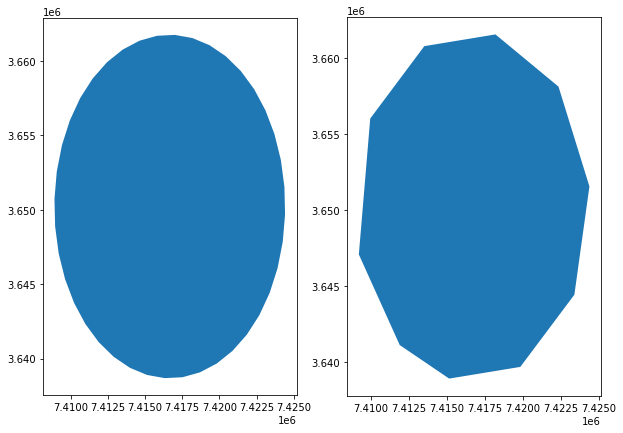

In [202]:
n= 10
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
places[places['cluster']==n].geometry.plot(ax = ax1) 
sim[sim['cluster']==n].geometry.plot(ax = ax2)

#### Format Biodiversity data

In [60]:
### Ids of lookup tables for each taxa in ArcGIS online
lookups = {'amphibians':'c221a727e12048b2a6ec8e762bc5f478',
         'birds':'bcb31fd9091446a0af3cfdaed334a8da',
         'mammals':'212a3dd4665845deb5d2adf5b597aae0',
         'reptiles':'5b606a03b3fc431e8d4b9191c88bc2b9'}

# Get data for all taxa
amphibians = format_df(path_in, 'Sample_amph_nozeroes.csv', lookups['amphibians'])
birds = format_df(path_in, 'Sample_birds_nozeroes.csv', lookups['birds'])
mammals = format_df(path_in, 'Sample_mammals_nozeroes.csv', lookups['mammals'])
reptiles = format_df(path_in, 'Sample_reptiles_nozeroes.csv', lookups['reptiles'])


In [61]:
# Format biodiversity data
amphibians = amphibians.groupby('MOL_ID')[['SliceNumber', 'per_global', 'per_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('amphibians').reset_index()
birds = birds.groupby('MOL_ID')[['SliceNumber', 'per_global', 'per_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('birds').reset_index()
mammals = mammals.groupby('MOL_ID')[['SliceNumber', 'per_global', 'per_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('mammals').reset_index()
reptiles = reptiles.groupby('MOL_ID')[['SliceNumber', 'per_global', 'per_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('reptiles').reset_index()

In [77]:
# Merge biodiversity data
sim = pd.merge(sim, amphibians, how='left', on = 'MOL_ID')
sim = pd.merge(sim, birds, how='left', on = 'MOL_ID')
sim = pd.merge(sim, mammals, how='left', on = 'MOL_ID')
sim = pd.merge(sim, reptiles, how='left', on = 'MOL_ID')
sim.head()

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,group,FID,geometry,amphibians,birds,mammals,reptiles
0,1,AFG,Afghanistan,1,60.222222,7687.504920,1,442334.303716,1.124109e+10,1,1,"POLYGON ((7827944.398 4014125.022, 7814867.987...","[{""SliceNumber"":951.0,""per_global"":4.02,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.02,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi..."
1,2,AFG,Afghanistan,2,60.222222,4706.088317,2,354254.657577,7.043484e+09,1,2,"POLYGON ((7884416.986 4117164.050, 7880408.999...","[{""SliceNumber"":951.0,""per_global"":4.19,""per_a...","[{""SliceNumber"":92.0,""per_global"":0.06,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.12,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.2,""per_aoi""..."
2,3,AFG,Afghanistan,3,52.312500,11768.366965,3,647899.188567,1.746601e+10,1,3,"POLYGON ((7661980.648 3995094.171, 7659753.669...","[{""SliceNumber"":32.0,""per_global"":100.0,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.04,""per_ao...","[{""SliceNumber"":167.0,""per_global"":1.69,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.63,""per_aoi..."
3,4,AFG,Afghanistan,4,45.500000,205.123344,4,63354.536671,2.958675e+08,1,4,"POLYGON ((7551032.457 3954283.587, 7548339.754...",NaN,"[{""SliceNumber"":26.0,""per_global"":0.0,""per_aoi...","[{""SliceNumber"":575.0,""per_global"":0.05,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.1,""per_aoi""..."
4,5,AFG,Afghanistan,5,45.500000,205.123344,5,63647.846097,2.979331e+08,1,5,"POLYGON ((7523202.584 3994616.263, 7520509.882...",NaN,"[{""SliceNumber"":26.0,""per_global"":0.0,""per_aoi...","[{""SliceNumber"":575.0,""per_global"":0.05,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.08,""per_aoi..."


In [78]:
sim.loc[sim['MOL_ID']==1,'amphibians'].values[0]

'[{"SliceNumber":951.0,"per_global":4.02,"per_aoi":53.98},{"SliceNumber":1191.0,"per_global":85.71,"per_aoi":0.08},{"SliceNumber":1707.0,"per_global":0.18,"per_aoi":85.88},{"SliceNumber":1935.0,"per_global":0.12,"per_aoi":52.01},{"SliceNumber":2224.0,"per_global":0.01,"per_aoi":5.97}]'

In [79]:
sim.to_file(f"{path_out}/top_places_precalculated_biodiv_simp.geojson",driver='GeoJSON') 
# places.to_csv(f"{path_out}/top_places_precalculated_biodiv.csv")

#### Format contextual data

In [80]:
### Read files (Files coming from ArcGIS project Places_HE_Future and expoprted as csv)
### Top 20 places original geometries from Scott: https://eowilson.maps.arcgis.com/home/item.html?id=4848c6b08fac4fa5bff40e9331b6d291
elu= pd.read_csv(f'{path_in}/Places_elu.csv')
le= pd.read_csv(f'{path_in}/Places_encroachment.csv')
pop= pd.read_csv(f'{path_in}/Places_pop.csv')
wp= pd.read_csv(f'{path_in}/wdpa_protection.csv')

cont_lookups={'elu':'83802a7fa3d34c1fa40844fc14683966',
              'landencroach':'b0ad58e2b2404eec811b711b604b9d55'}

In [81]:
elu = elu.rename(columns ={'OBJECTID_1':'MOL_ID'})
le = le.rename(columns ={'OBJECTID_1':'MOL_ID'})
pop = pop.rename(columns ={'OBJECTID_1':'MOL_ID'})

In [82]:
wp.head(1)

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,SUM,percentage_protected
0,1,2,19.0,19000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,1013.981747,0.13


For elu layer there are some rows that were not processed in Arcgis Pro (the geometries were not rasterized). To know which geometries are not included in elu table do this and repeat analysis in arcgis pro only for those rows.

In [83]:
l = list(range(1,1926))

In [84]:
l = list(set(places.MOL_ID) - set(elu.MOL_ID))
len(l) # number of geometries that have no elu data, repeat analysis in ArcGIS Pro for those

92

In [85]:
# Read elu table with new rows
elu2= pd.read_csv(f'{path_in}/Places_elu_nulls.csv')

In [86]:
# Merge elu datasets
elu = elu.append(elu2)
elu.head(1)

,OID_,MOL_ID,COUNT,AREA,MAJORITY
0,1,1,148821.0,0.750596,184


In [87]:
l = list(set(places.MOL_ID) - set(elu.MOL_ID))
len(l) # those geometries don't have elu data

25

In [75]:
### Column names needed: 
# 'percent_irrigated', 'percent_rainfed',
#        'percent_rangeland', 'percent_urban', 'population_sum',
#        'majority_land_cover_climate_regime', 'land_cover_majority',
#        'climate_regime_majority',

Index(['Unnamed: 0', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'MOL_ID',
       'AREA_KM2', 'reptiles', 'amphibians', 'mammals', 'birds',
       'percentage_protected', 'percent_irrigated', 'percent_rainfed',
       'percent_rangeland', 'percent_urban', 'population_sum',
       'majority_land_cover_climate_regime', 'land_cover_majority',
       'climate_regime_majority', 'country_size'],
      dtype='object')

In [88]:
## Add contextual data: ELU
sim = sim.merge(elu[['MOL_ID','MAJORITY']], how='left', on = 'MOL_ID').rename(columns={'MAJORITY':'majority_land_cover_climate_regime'})

In [89]:
sim.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,group,FID,geometry,amphibians,birds,mammals,reptiles,majority_land_cover_climate_regime
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,1,1,"POLYGON ((7827944.398 4014125.022, 7814867.987...","[{""SliceNumber"":951.0,""per_global"":4.02,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.02,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi...",184.0


In [90]:
# Retrieve elu lookup table to see to see the correspondences for that elu code
elu_lookup = getHTfromId(cont_lookups['elu'])
elu_lookup.head()

,elu_code,elu,lc_type,lf_type,cr_type,ObjectId
0,301,Sub Tropical Moist Forest on Plains,Forest,Plains,Sub Tropical Moist,1
1,201,Warm Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Plains,Warm Temperate Dry,2
2,151,Cool Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Plains,Cool Temperate Dry,3
3,302,Sub Tropical Moist Cropland on Tablelands,Cropland,Tablelands,Sub Tropical Moist,4
4,152,Cool Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Tablelands,Cool Temperate Dry,5


In [91]:
# Merge in dataset the required info from lookup table
psim = sim.merge(elu_lookup[['elu_code','lc_type','cr_type']], how='left', left_on = 'majority_land_cover_climate_regime', right_on = 'elu_code')\
    .drop(columns=['elu_code'])\
    .rename(columns={'lc_type':'land_cover_majority','cr_type':'climate_regime_majority'})

In [92]:
sim.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,group,FID,geometry,amphibians,birds,mammals,reptiles,majority_land_cover_climate_regime
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,1,1,"POLYGON ((7827944.398 4014125.022, 7814867.987...","[{""SliceNumber"":951.0,""per_global"":4.02,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.02,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi...",184.0


In [93]:
# Each slicenumber with a type of land encroachment
le.head(1)

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,MIN,MAX,RANGE,MEAN,STD,SUM,MEDIAN,PCT90,percentage_land_encroachment
0,1,1,2846.0,0.197635,Variable_new,SliceNumber,1.0,0.276261,0.814483,0.538222,0.462732,0.133903,1316.934454,0.408784,0.684398,26.31


In [94]:
# Check geometries that have no land encroachment data
l = list(set(places.MOL_ID) - set(le.MOL_ID))
len(l) # repeat analysis for those

391

In [95]:
# Upload results from second analysis
le2 = pd.read_csv(f'{path_in}/Places_encroachment_nulls.csv')
le2.head(1)

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,MIN,MAX,RANGE,MEAN,STD,SUM,MEDIAN,PCT90,Total,percentage_land_encroachment
0,1,157,250.0,0.017361,Variable_new,SliceNumber,1.0,0.213953,0.86497,0.651016,0.658066,0.121977,164.516578,0.695782,0.750065,1033.0,24.2


In [96]:
le2 = le2.drop(columns={'Total'})
le2.head()

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,MIN,MAX,RANGE,MEAN,STD,SUM,MEDIAN,PCT90,percentage_land_encroachment
0,1,157,250.0,0.017361,Variable_new,SliceNumber,1.0,0.213953,0.864970,0.651016,0.658066,0.121977,164.516578,0.695782,0.750065,24.20
1,2,162,20.0,0.001389,Variable_new,SliceNumber,1.0,0.261984,0.613937,0.351953,0.409149,0.138521,8.182981,0.391272,0.612955,0.93
2,3,223,97.0,0.006736,Variable_new,SliceNumber,1.0,0.190901,0.710594,0.519693,0.415030,0.154798,40.257863,0.380945,0.607992,4.94
3,4,343,1414.0,0.098193,Variable_new,SliceNumber,1.0,0.231417,0.844146,0.612730,0.426742,0.120487,603.412633,0.397267,0.589707,8.95
4,5,344,31.0,0.002153,Variable_new,SliceNumber,1.0,0.357714,0.548353,0.190639,0.431293,0.056941,13.370077,0.421643,0.513450,0.19


In [97]:
# Merge both land encroachment datasets
le = le.append(le2)
le.head(1)

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,MIN,MAX,RANGE,MEAN,STD,SUM,MEDIAN,PCT90,percentage_land_encroachment
0,1,1,2846.0,0.197635,Variable_new,SliceNumber,1.0,0.276261,0.814483,0.538222,0.462732,0.133903,1316.934454,0.408784,0.684398,26.31


In [98]:
# Check geometries that have no land encroachment data
l = list(set(places.MOL_ID) - set(le.MOL_ID))
len(l) # those geometries don't have le data

190

In [99]:
# See all land encroachment data for each mol_id
long =le[['SliceNumber','MOL_ID','percentage_land_encroachment']].pivot(index='MOL_ID', columns='SliceNumber', values='percentage_land_encroachment').reset_index().rename(columns=
                                                                                                                              {1.0:'percent_irrigated',
                                                                                                                              2.0:'percent_rainfed',
                                                                                                                              3.0:'percent_rangeland',
                                                                                                                                 4.0:'percent_urban'})

In [100]:
long.head(1)

SliceNumber,MOL_ID,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban
0,1,26.31,57.02,15.5,NaN


In [101]:
# How many encroachment values are higher than 100? This can be due to the way the area is calculated. Anyway, the website will show only the le that is 
# majoritary and the % will stop at 100%
long['sum']=long.iloc[:, 1:5].sum(axis=1)
long[long['sum']>100]

SliceNumber,MOL_ID,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,sum
2,3,33.07,6.93,111.57,2.66,154.23
5,7,14.04,0.93,101.45,0.14,116.56
19,22,NaN,23.95,108.24,0.74,132.93
20,23,0.67,147.48,43.64,2.01,193.80
24,28,11.90,118.87,26.94,2.91,160.62
...,...,...,...,...,...,...
1637,1825,4.79,12.90,153.44,8.54,179.67
1685,1878,1.22,50.35,106.65,10.75,168.97
1686,1879,20.71,16.55,81.57,3.66,122.49
1702,1895,NaN,NaN,139.54,NaN,139.54


In [102]:
## Add contextual data: Land Encroachment
sim = sim.merge(long[['MOL_ID','percent_irrigated', 'percent_rainfed', 'percent_rangeland','percent_urban']],on ='MOL_ID',how='left')

In [103]:
sim.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,group,...,geometry,amphibians,birds,mammals,reptiles,majority_land_cover_climate_regime,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,1,...,"POLYGON ((7827944.398 4014125.022, 7814867.987...","[{""SliceNumber"":951.0,""per_global"":4.02,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.02,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi...",184.0,26.31,57.02,15.5,NaN


In [104]:
# Population table, we need the SUM attribute
pop.head(1)

,OID_,MOL_ID,COUNT,AREA,SUM
0,1,1,10824.0,0.751667,2.092001e+06


In [108]:
## Add contextual data: POP
sim = sim.merge(pop[['MOL_ID','SUM']],on ='MOL_ID',how='left')
sim.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,group,...,amphibians,birds,mammals,reptiles,majority_land_cover_climate_regime,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,SUM
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,1,...,"[{""SliceNumber"":951.0,""per_global"":4.02,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.02,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi...",184.0,26.31,57.02,15.5,NaN,2.092001e+06


In [109]:
sim = sim.rename(columns ={'SUM':'population_sum'})
sim.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,group,...,amphibians,birds,mammals,reptiles,majority_land_cover_climate_regime,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,population_sum
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,1,...,"[{""SliceNumber"":951.0,""per_global"":4.02,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.02,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi...",184.0,26.31,57.02,15.5,NaN,2.092001e+06


In [110]:
wp.head()

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,SUM,percentage_protected
0,1,2,19.0,19000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,1013.981747,0.13
1,2,3,8.0,8000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,232.988981,0.03
2,3,4,68.0,68000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,5466.303537,0.71
3,4,14,490.0,490000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,40076.577079,5.21
4,5,18,124.0,124000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,11443.240224,1.49


In [111]:
## Add contextual data: POP
sim = sim.merge(wp[['MOL_ID','percentage_protected']],on ='MOL_ID',how='left')
sim.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,group,...,birds,mammals,reptiles,majority_land_cover_climate_regime,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,population_sum,percentage_protected
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,1,...,"[{""SliceNumber"":26.0,""per_global"":0.02,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi...",184.0,26.31,57.02,15.5,NaN,2.092001e+06,NaN


In [112]:
sim.head(10)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,group,...,birds,mammals,reptiles,majority_land_cover_climate_regime,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,population_sum,percentage_protected
0,1,AFG,Afghanistan,1,60.222222,7687.504920,1,442334.303716,1.124109e+10,1,...,"[{""SliceNumber"":26.0,""per_global"":0.02,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi...",184.0,26.31,57.02,15.50,NaN,2.092001e+06,NaN
1,2,AFG,Afghanistan,2,60.222222,4706.088317,2,354254.657577,7.043484e+09,1,...,"[{""SliceNumber"":92.0,""per_global"":0.06,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.12,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.2,""per_aoi""...",176.0,1.56,55.09,5.24,NaN,6.288113e+05,0.13
2,3,AFG,Afghanistan,3,52.312500,11768.366965,3,647899.188567,1.746601e+10,1,...,"[{""SliceNumber"":26.0,""per_global"":0.04,""per_ao...","[{""SliceNumber"":167.0,""per_global"":1.69,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.63,""per_aoi...",142.0,33.07,6.93,111.57,2.66,6.122301e+06,0.03
3,4,AFG,Afghanistan,4,45.500000,205.123344,4,63354.536671,2.958675e+08,1,...,"[{""SliceNumber"":26.0,""per_global"":0.0,""per_aoi...","[{""SliceNumber"":575.0,""per_global"":0.05,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.1,""per_aoi""...",142.0,0.88,NaN,1.77,NaN,3.773772e+03,0.71
4,5,AFG,Afghanistan,5,45.500000,205.123344,5,63647.846097,2.979331e+08,1,...,"[{""SliceNumber"":26.0,""per_global"":0.0,""per_aoi...","[{""SliceNumber"":575.0,""per_global"":0.05,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.08,""per_aoi...",142.0,NaN,NaN,2.64,NaN,1.882826e+03,NaN
5,6,AFG,Afghanistan,6,45.000000,205.123344,6,60084.865949,2.726637e+08,1,...,"[{""SliceNumber"":123.0,""per_global"":0.0,""per_ao...","[{""SliceNumber"":575.0,""per_global"":0.04,""per_a...","[{""SliceNumber"":57.0,""per_global"":0.02,""per_ao...",273.0,NaN,NaN,NaN,NaN,6.723271e+03,NaN
6,7,AFG,Afghanistan,7,43.538462,9262.838696,7,449212.586279,1.268476e+10,1,...,"[{""SliceNumber"":26.0,""per_global"":0.01,""per_ao...","[{""SliceNumber"":575.0,""per_global"":1.07,""per_a...","[{""SliceNumber"":57.0,""per_global"":0.99,""per_ao...",283.0,14.04,0.93,101.45,0.14,4.315277e+05,NaN
7,8,AFG,Afghanistan,8,42.000000,3949.445557,8,272991.094787,5.269999e+09,1,...,"[{""SliceNumber"":123.0,""per_global"":0.03,""per_a...","[{""SliceNumber"":575.0,""per_global"":0.98,""per_a...","[{""SliceNumber"":57.0,""per_global"":0.45,""per_ao...",283.0,NaN,NaN,34.82,NaN,4.230695e+03,NaN
8,9,AFG,Afghanistan,9,42.000000,205.123344,9,60084.865956,2.726637e+08,1,...,"[{""SliceNumber"":423.0,""per_global"":0.0,""per_ao...","[{""SliceNumber"":575.0,""per_global"":0.05,""per_a...","[{""SliceNumber"":57.0,""per_global"":0.02,""per_ao...",283.0,NaN,NaN,1.14,NaN,9.582674e+02,NaN
9,10,AFG,Afghanistan,10,42.000000,205.123344,10,61232.826283,2.808491e+08,1,...,"[{""SliceNumber"":26.0,""per_global"":0.0,""per_aoi...","[{""SliceNumber"":575.0,""per_global"":0.05,""per_a...","[{""SliceNumber"":57.0,""per_global"":0.02,""per_ao...",186.0,0.19,0.50,1.87,NaN,1.314997e+04,NaN


In [113]:
sim = sim.fillna(0)

In [114]:
sim.loc[places['MOL_ID']==20,'mammals'].values[0] # check the string to see it's formatted correctly 

'[{"SliceNumber":575.0,"per_global":0.19,"per_aoi":87.54},{"SliceNumber":605.0,"per_global":0.0,"per_aoi":77.68},{"SliceNumber":607.0,"per_global":0.01,"per_aoi":86.61},{"SliceNumber":609.0,"per_global":0.0,"per_aoi":94.73},{"SliceNumber":615.0,"per_global":0.04,"per_aoi":67.36},{"SliceNumber":635.0,"per_global":0.0,"per_aoi":90.78},{"SliceNumber":1176.0,"per_global":0.09,"per_aoi":44.75},{"SliceNumber":1613.0,"per_global":0.05,"per_aoi":11.83},{"SliceNumber":1784.0,"per_global":0.0,"per_aoi":0.12},{"SliceNumber":1787.0,"per_global":0.0,"per_aoi":95.77},{"SliceNumber":1955.0,"per_global":0.01,"per_aoi":65.97},{"SliceNumber":2106.0,"per_global":0.01,"per_aoi":94.73},{"SliceNumber":2240.0,"per_global":0.01,"per_aoi":81.62},{"SliceNumber":2335.0,"per_global":0.01,"per_aoi":42.9},{"SliceNumber":2341.0,"per_global":0.0,"per_aoi":0.12},{"SliceNumber":2811.0,"per_global":0.17,"per_aoi":69.22},{"SliceNumber":2889.0,"per_global":0.0,"per_aoi":97.86},{"SliceNumber":2927.0,"per_global":0.04,"per_

In [116]:
sim.columns

Index(['OBJECTID', 'GID_0', 'NAME_0', 'cluster', 'PRmean', 'AREA_KM2',
       'MOL_ID', 'Shape_Leng', 'Shape_Area', 'group', 'FID', 'geometry',
       'amphibians', 'birds', 'mammals', 'reptiles',
       'majority_land_cover_climate_regime', 'percent_irrigated',
       'percent_rainfed', 'percent_rangeland', 'percent_urban',
       'population_sum', 'percentage_protected'],
      dtype='object')

In [117]:
sim[sim['MOL_ID']!=sim['cluster']]

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,group,...,birds,mammals,reptiles,majority_land_cover_climate_regime,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,population_sum,percentage_protected


In [119]:
sim.to_file(f"{path_out}/top_places_precalculated_20220601.geojson",driver='GeoJSON')
